# Models intro

- CNN and RNN models
- Use multiple stocks as data, train one general model that works on multiple stocks
- Multi category includes sell, neutral, buy classes
- Binary category includes non-buy, buy classes

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GlobalAveragePooling1D
# from tensorflow.keras.metrics import Precision, AUC

import tensorflow.keras.metrics as metrics


import scripts.feature as feat
import scripts.utility as util


# Multi ticker

In [7]:
# ticker_list = ["TSLA", "NVDA", "AMZN"]
ticker_list = ["TSLA", "NVDA", "AMZN", "AAPL", "MSFT", "AMD", "GOOG", "META"]

X_train, y_train, X_val, y_val = [], [], [], []

for ticker in ticker_list:
    df = yf.download(ticker, period="5y", interval="1d", progress=False)
    df = df.drop(columns=["Adj Close"])

    entry = feat.objective(df, days=5, threshold=0.05)
    df = feat.feature_engineering(df)
    df["entry"] = entry.values
    df = df.dropna()

    train, val = util.split_train_val(df, 0.8)

    t_x, t_y = util.split_window(train.drop(columns=["entry"]), train["entry"], sequence_length=15)
    v_x, v_y = util.split_window(val.drop(columns=["entry"]), val["entry"], sequence_length=15)

    X_train.append(t_x)
    y_train.append(t_y)
    X_val.append(v_x)
    y_val.append(v_y)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_val = np.vstack(X_val)
y_val = np.hstack(y_val)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7720, 15, 25) (7720,)
(1848, 15, 25) (1848,)


## Multi-category case


In [8]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1, 2], dtype=int64), array([2027, 3138, 2555], dtype=int64))
(array([0, 1, 2], dtype=int64), array([356, 999, 493], dtype=int64))


In [9]:
class_weight = {0: 1.5, 1: 1., 2:2.}


### CNN

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3440 - loss: 1.6072 - precision: 0.6556 - val_accuracy: 0.3593 - val_loss: 1.0972 - val_precision: 0.7512
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4026 - loss: 1.4960 - precision: 0.7261 - val_accuracy: 0.4562 - val_loss: 1.0409 - val_precision: 0.7474
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4302 - loss: 1.4797 - precision: 0.7274 - val_accuracy: 0.3517 - val_loss: 1.1163 - val_precision: 0.7284
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4525 - loss: 1.4500 - precision: 0.7463 - val_accuracy: 0.4345 - val_loss: 1.0477 - val_precision: 0.7114
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4453 - loss: 1.4514 - precision: 0.7187 - val_accuracy: 0.4854 - val_loss: 1.0197 - val_precision: 0.7188
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4710 - loss: 1.4224 - precision: 0.6515 - val_accuracy: 0.4205 - val_loss:

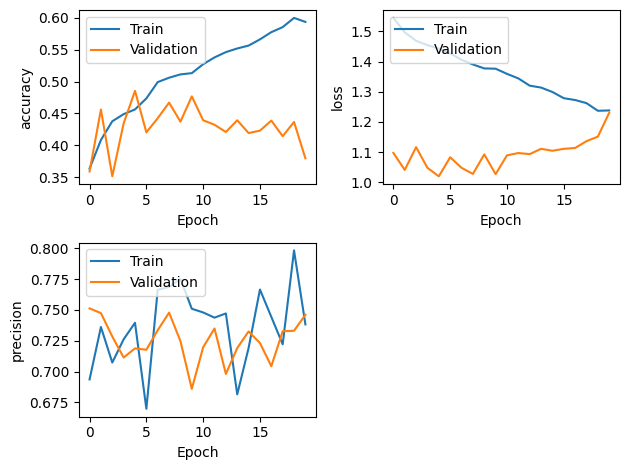

In [10]:
multi_cat_cnn = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

# multi_cat_cnn.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

multi_cat_cnn.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy", metrics.Precision(thresholds=0.4, class_id=2)]
)

history = multi_cat_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    shuffle=True,
    class_weight=class_weight
)

# util.plot_training_result(history)
util.plot_training_result(history)


Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3886 - loss: 1.5227 - precision_1: 0.7791 - val_accuracy: 0.4069 - val_loss: 1.0903 - val_precision_1: 0.7473
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4574 - loss: 1.4353 - precision_1: 0.7076 - val_accuracy: 0.4886 - val_loss: 1.0180 - val_precision_1: 0.7040
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5158 - loss: 1.3748 - precision_1: 0.7707 - val_accuracy: 0.4378 - val_loss: 1.0993 - val_precision_1: 0.7550
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5816 - loss: 1.2721 - precision_1: 0.6974 - val_accuracy: 0.4870 - val_loss: 1.0862 - val_precision_1: 0.7441
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6051 - loss: 1.1915 - precision_1: 0.7657 - val_accuracy: 0.4870 - val_loss: 1.1180 - val_precision_1: 0.7318
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6719 - loss: 1.0688 - precision_1: 0.6977 - val_accura

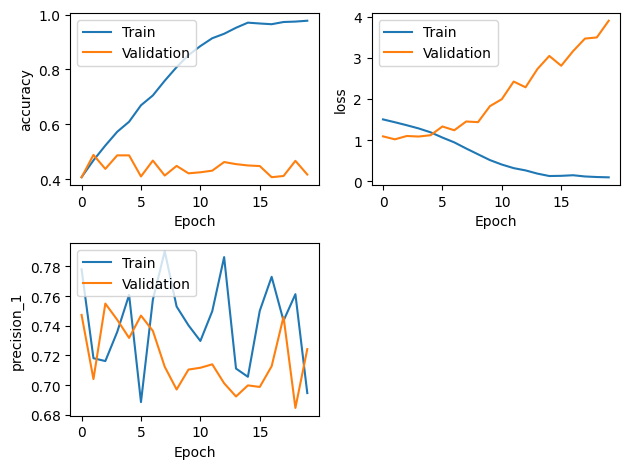

In [11]:
multi_cat_cnn = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation="relu"),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

# multi_cat_cnn.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

multi_cat_cnn.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy", metrics.Precision(thresholds=0.4, class_id=2)]
)

history = multi_cat_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    shuffle=True,
    class_weight=class_weight
)

# util.plot_training_result(history)
util.plot_training_result(history)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3819 - loss: 1.5290 - precision_2: 0.8043 - val_accuracy: 0.3209 - val_loss: 1.0852 - val_precision_2: 0.7506
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4351 - loss: 1.4613 - precision_2: 0.6573 - val_accuracy: 0.4886 - val_loss: 1.0207 - val_precision_2: 0.7459
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4745 - loss: 1.4154 - precision_2: 0.7561 - val_accuracy: 0.4107 - val_loss: 1.1168 - val_precision_2: 0.7429
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5050 - loss: 1.3919 - precision_2: 0.7889 - val_accuracy: 0.4437 - val_loss: 1.1361 - val_precision_2: 0.7553
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5405 - loss: 1.3425 - precision_2: 0.6900 - val_accuracy: 0.4459 - val_loss: 1.1288 - val_precision_2: 0.7351
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5387 - loss: 1.3470 - precision_2: 0.7815 - val_accura

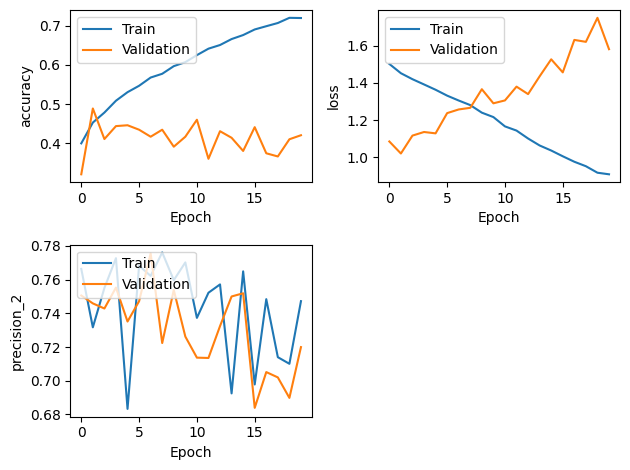

In [12]:
multi_cat_cnn = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation="relu"),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

# multi_cat_cnn.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

multi_cat_cnn.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy", metrics.Precision(thresholds=0.4, class_id=2)]
)

history = multi_cat_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    shuffle=True,
    class_weight=class_weight
)

# util.plot_training_result(history)
util.plot_training_result(history)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4181 - loss: 1.5525 - precision_4: 0.7150 - val_accuracy: 0.3853 - val_loss: 1.0906 - val_precision_4: 0.7599
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4651 - loss: 1.4398 - precision_4: 0.7082 - val_accuracy: 0.4372 - val_loss: 1.0578 - val_precision_4: 0.7165
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4980 - loss: 1.3840 - precision_4: 0.7077 - val_accuracy: 0.4989 - val_loss: 1.0134 - val_precision_4: 0.7238
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 1.3439 - precision_4: 0.7119 - val_accuracy: 0.4865 - val_loss: 1.0243 - val_precision_4: 0.7048
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 1.3194 - precision_4: 0.7669 - val_accuracy: 0.4399 - val_loss: 1.0997 - val_precision_4: 0.7134
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5777 - loss: 1.2624 - precision_4: 0.7063 - val_accura

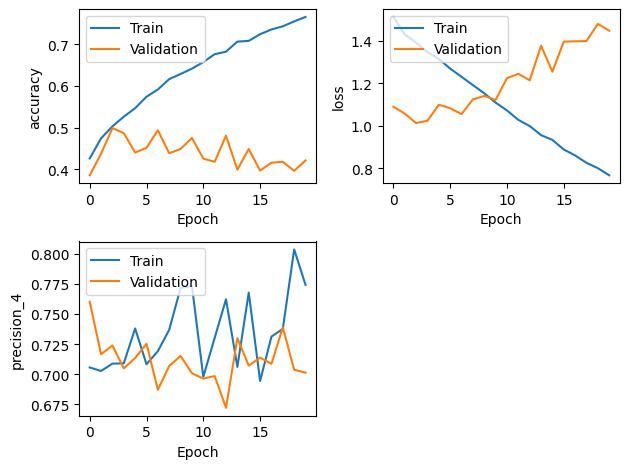

In [14]:
multi_cat_cnn = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation="relu"),
        Flatten(),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

# multi_cat_cnn.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

multi_cat_cnn.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy", metrics.Precision(thresholds=0.4, class_id=2)]
)

history = multi_cat_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    shuffle=True,
    class_weight=class_weight
)

# util.plot_training_result(history)
util.plot_training_result(history)

### RNN

In [19]:
multi_cat_rnn = Sequential(
    [
        LSTM(
            64, activation="relu", input_shape=X_train.shape[1:], return_sequences=True
        ),
        LSTM(32, activation="relu"),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

multi_cat_rnn.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


c:\Users\edton\miniconda3\envs\trading\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3464 - loss: 1.5436 - val_accuracy: 0.4096 - val_loss: 1.0897
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4478 - loss: 1.4595 - val_accuracy: 0.4259 - val_loss: 1.0676
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4722 - loss: 1.4306 - val_accuracy: 0.4497 - val_loss: 1.1112
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5130 - loss: 1.3994 - val_accuracy: 0.5005 - val_loss: 1.0099
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5352 - loss: 1.3638 - val_accuracy: 0.5032 - val_loss: 1.0493
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5484 - loss: 1.3263 - val_accuracy: 0.5065 - val_loss: 1.0989
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5611 - loss: 1.3010 - val_accuracy: 0.4242 - val_loss: 1.2071
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5846 - loss: 1.2737 - val_accurac

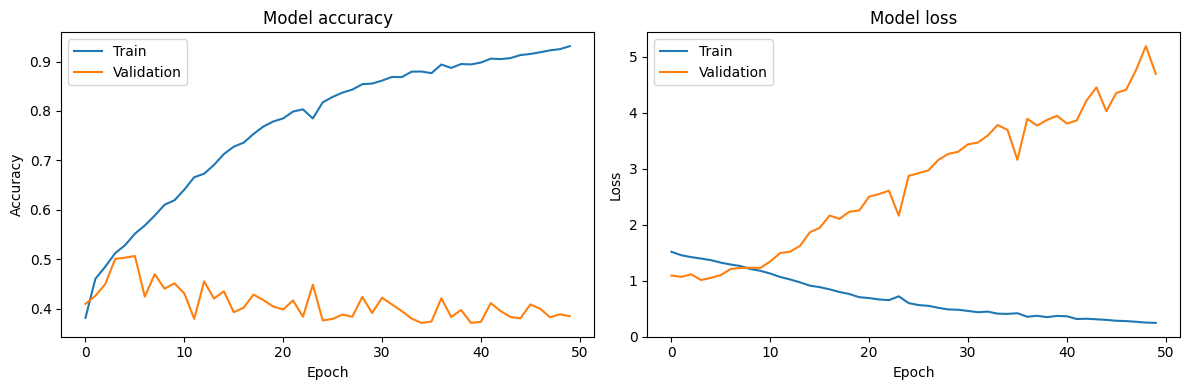

In [20]:
history = multi_cat_rnn.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)

## Binary case

In [15]:
y_train_binary = np.where(y_train <= 1, 0, 1)
y_val_binary = np.where(y_val <= 1, 0, 1)
print(np.unique(y_train_binary, return_counts=True))
print(np.unique(y_val_binary, return_counts=True))

(array([0, 1]), array([5165, 2555], dtype=int64))
(array([0, 1]), array([1355,  493], dtype=int64))


In [16]:
class_weight = {0: 1., 1: 2.}

### CNN

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5355 - loss: 0.2408 - precision_12: 0.3638 - val_accuracy: 0.6494 - val_loss: 0.1662 - val_precision_12: 0.0000e+00
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5867 - loss: 0.2253 - precision_12: 0.6505 - val_accuracy: 0.7240 - val_loss: 0.1593 - val_precision_12: 0.0000e+00
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5941 - loss: 0.2260 - precision_12: 0.6610 - val_accuracy: 0.6672 - val_loss: 0.1601 - val_precision_12: 0.0000e+00
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6103 - loss: 0.2229 - precision_12: 0.6172 - val_accuracy: 0.5768 - val_loss: 0.1689 - val_precision_12: 0.0000e+00
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5881 - loss: 0.2244 - precision_12: 0.5572 - val_accuracy: 0.7105 - val_loss: 0.1558 - val_precision_12: 0.0000e+00
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6121 - loss: 0.2201 - pr

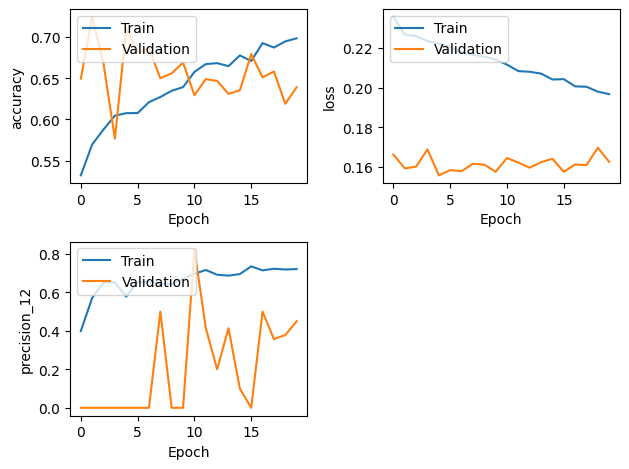

In [27]:
binary_cat_cnn = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),  # 1 classes for binary
    ]
)

binary_cat_cnn.compile(
    optimizer="adam",
    loss="BinaryFocalCrossentropy",
    metrics=["accuracy", metrics.Precision(thresholds=0.6, class_id=0)],  
)

history = binary_cat_cnn.fit(
    X_train, y_train_binary,
    epochs=20,
    validation_data=(X_val, y_val_binary),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5421 - loss: 0.3004 - precision_13: 0.4124 - val_accuracy: 0.6310 - val_loss: 0.1635 - val_precision_13: 0.0000e+00
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5799 - loss: 0.2316 - precision_13: 0.4747 - val_accuracy: 0.5931 - val_loss: 0.1677 - val_precision_13: 0.5000
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6023 - loss: 0.2243 - precision_13: 0.6308 - val_accuracy: 0.6661 - val_loss: 0.1582 - val_precision_13: 0.0000e+00
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6299 - loss: 0.2186 - precision_13: 0.6656 - val_accuracy: 0.6872 - val_loss: 0.1581 - val_precision_13: 1.0000
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6495 - loss: 0.2142 - precision_13: 0.6580 - val_accuracy: 0.6872 - val_loss: 0.1571 - val_precision_13: 0.6667
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6532 - loss: 0.2150 - precision_13: 

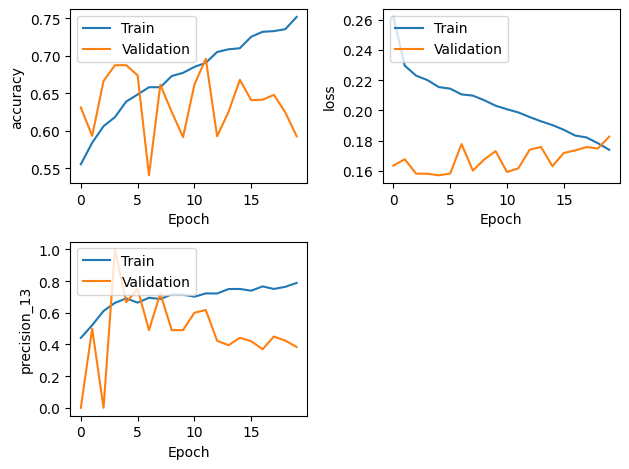

In [28]:
binary_cat_cnn = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),  # 1 classes for binary
    ]
)

binary_cat_cnn.compile(
    optimizer="adam",
    loss="BinaryFocalCrossentropy",
    metrics=["accuracy", metrics.Precision(thresholds=0.6, class_id=0)],  
)

history = binary_cat_cnn.fit(
    X_train, y_train_binary,
    epochs=20,
    validation_data=(X_val, y_val_binary),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)

### RNN

In [25]:
binary_cat_rnn = Sequential(
    [
        LSTM(
            64, activation="relu", input_shape=X_train.shape[1:], return_sequences=True
        ),
        LSTM(32, activation="relu"),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="sigmoid"),  # 3 classes for classification
    ]
)

binary_cat_rnn.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)


In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4636 - loss: 1.0750 - val_accuracy: 0.7132 - val_loss: 0.6217
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6087 - loss: 0.8985 - val_accuracy: 0.6353 - val_loss: 0.6723
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6132 - loss: 0.8916 - val_accuracy: 0.6861 - val_loss: 0.6308
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6155 - loss: 0.8745 - val_accuracy: 0.6537 - val_loss: 0.6367
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6287 - loss: 0.8588 - val_accuracy: 0.6190 - val_loss: 0.6619
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6377 - loss: 0.8401 - val_accuracy: 0.6142 - val_loss: 0.6712
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6591 - loss: 0.8076 - val_accuracy: 0.6472 - val_loss: 0.6945
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6751 - loss: 0.7765 - val_accuracy

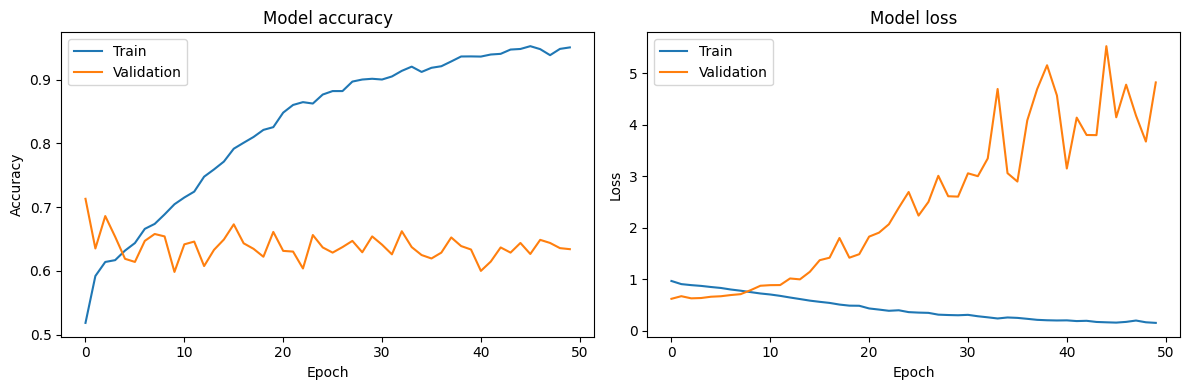

In [26]:
history = binary_cat_rnn.fit(
    X_train, y_train_binary,
    epochs=50,
    validation_data=(X_val, y_val_binary),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)